### Computer Vision & Convolutional Neural Networks

* If you can see it, it can be a computer vision problem
  * Steak or Pizza in an image, binary-classification
    * It learns the patterns itself
  * Sushi, Steak, or Pizza multi-classification
  * Object detection, find things in video
  * Segmentation, pull out something from an image
    * Isolate a single person or object in an image

Apple and Tesla have very bleeding edge computer vision
  * Turning x cameras into a vector to represent video as data for machine learning
  * Tesla uses pytorch

### Computer Vision Input and Output Shapes

* **Data:** Width, Height, Color Channels (RGB) 24 bit
* Represent the image as numbers in a tensor
* Existing algorithms exist for most computer vision problems
* 1 output for each class (steak sushi pizza etc...) could be 100 or 1000 classes

The type of model that is best suited for this is **Convolutional Neural Network** or a **CNN**

**Transformer** models can also work here.

* CNN
  * Process sequential data
  * Does not use attention mechanisms
  * Heirarchical features, pooling, downsampling
  * Image or spatial data
  * Need to find local patterns and features in the data
  * Does not require long range dependencies on input data
* Transformer
  * Mostly uses for natural language processing
  * Relies on attention mechanisms *(Selectively focuses on specific parts of input data)*
  * Multiheaded attention, position-wise embeddings
  * Use with text or speech
  * Use when you need to capture long range dependencies in the input sequence
  * Your model needs a complex relationship between elements of input data



### Input and Output Shapes

`Shape = [None, 224, 224, 3] # None = batch size`

or

`Shape = [32, 224, 224, 3] # 32 = batch size`

The larger the image size the bigger the computation. Smaller image, less data, but faster, not rocket science.

This should scale up and down in size and even color vs grayscal

* 2 ways to shape the tensors
  * `[batch_size, height, width, color_chan]` = NHWC (number in batch H W Color)
  * `[batch_size, color_chan, height, width]` = NCHW
  * Many libs want NHWC, pytorch defaults to NCHW

### What is a Convolutional Neural Network? (CNN)

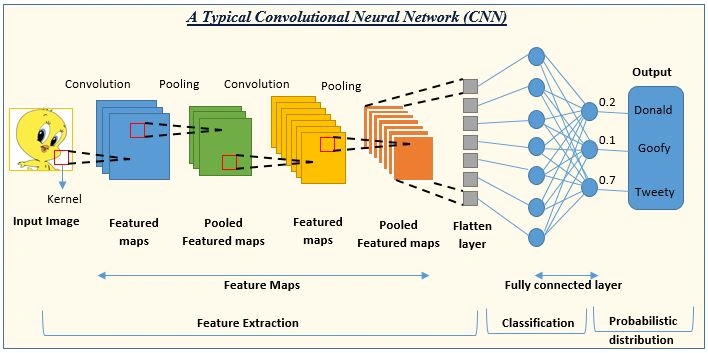

* Hyperparameter/Layer Type
  * Input Images
    * Images to discover patterns in
  * Input Layer
    * Preprocesses target images
  * Convolutional Layer
    * Learns most important features from the target images
  * Hidden Activation/Non-Linear Activation
    * Handle non straight lines
    * `torch.nn.ReLU()` etc... to handle non straight things
  * Pooling Layer
    * Reduces dimensionality of learned features in the image
  * Output Layer/Linear Layer
    * Takes learned features and output them in the shape of the target labels
  * Output Activation
    * Converts output logits to prediction probablilites

### Computer Vision Libs

* `torchvision` - Base lib for PyTorch computer vision
* `torchvision.datasets` - Dataset and dataloading functions
* `torchvision.models` - Pretrained computer vision models
* `torchvision.transforms` - Functions for manipulating images for use with an ML model
  * Turn into numbers so we can run ML/DL against the images
* `torch.utils.data.Dataset` - Base dataset class for 
* `torch.utils.data.DataLoader` - Creates a python iterable over a dataset

In [86]:
# Import torch
import torch
from torch import nn

# Import Dataloader
from torch.utils.data import DataLoader

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import torchmetrics
import torchmetrics

# Import matplotlib
import matplotlib.pyplot as plt

# Import tqdm (for progress bars)
from tqdm.auto import tqdm

# Import pandas
import pandas as pd

# Import mlxtend
import mlxtend

# Import helper functions
import random
import requests
from pathlib import Path
# Download helper func from learn pytorch repo if its not downlaoded
if Path("helper_functions.py").is_file():
    print("File exists, skipping download")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
# Then import the file
from helper_functions import plot_predictions, plot_decision_boundary

# Import Timers
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference betweeen start and end time."""
    total_time = end - start
    print(f"Training time on {device}: {total_time:.12f} seconds")
    return total_time

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Random seed
RANDOM_SEED = 42

# Calculate accuracy out of 100 examples
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # item gets the value out as a single item, this also moves it to cpu
    acc = (correct / len(y_pred)) * 100
    return acc

# Check versions
print(torch.__version__)
print(torchvision.__version__)
#print(f"Device Type: {device} | Device Count: {cudacount}")
print(mlxtend.__version__)
print(device)

num_threads = torch.get_num_threads()
print(num_threads)


File exists, skipping download
2.5.1+cu124
0.20.1+cu124
0.23.3
cuda
6


### Getting a Dataset

We will be testing with the FashionMNIST dataset. Grayscale images of clothing. Train to understand different types of clothing.

Imagenet is the standard for test images. 168GB.

`torchvision.datasets.FashionMNIST` exists and allows you to call a download func etc... to grab the dataset, torchvision datasets are typically preformatted to work with torch already. Wild datasets will need labels/formatting.



In [87]:
print(device)

cuda


In [88]:
# Setup training data
train_data = datasets.FashionMNIST(
    root = "data", # where to download
    train = True, # do we want the training or testing dataste
    download = True, # do we want to download, y/n
    transform = torchvision.transforms.ToTensor(), # How do we want to xform the data
    target_transform = None # How do we want to xform the labels/targets
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

In [89]:
# How many samples do we have?
print(f"Training Data: {len(train_data)} | Testing Data: {len(test_data)}")

# We train on the training data and validate what we learn on the testing data

# Check class names
class_names = train_data.classes
print(class_names)

# Get a dictionary of the class names
class_to_idx = train_data.class_to_idx
print(class_to_idx)

# see the image
image, label = train_data[0]

# Check the shape of the image
print(f"Image shape [CC, H, W]: {image.shape} | Label: {label}")

Training Data: 60000 | Testing Data: 10000
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
Image shape [CC, H, W]: torch.Size([1, 28, 28]) | Label: 9


### Video 105 - Visualizing Random Samples of Data

In [90]:
print(device)

cuda


Image shape: Ptorch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

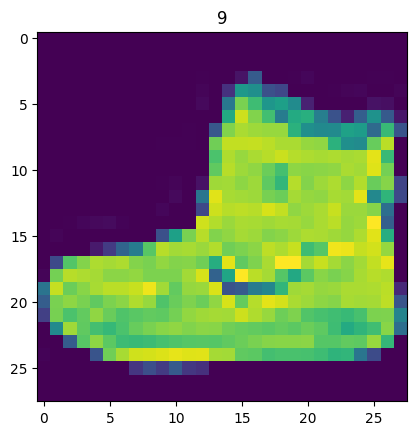

In [91]:
image, label = train_data[0]
print(f"Image shape: P{image.shape}")
plt.imshow(image.squeeze()) # The singular dimension is removed, which is the channel dim
plt.title(label)


Text(0.5, 1.0, 'Ankle boot')

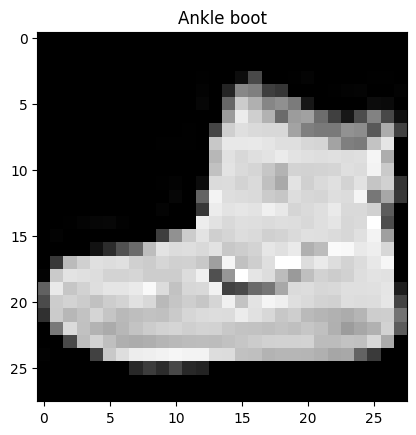

In [92]:
plt.imshow(image.squeeze(), cmap="gray") # cmap = colormap
plt.title(class_names[label])

In [93]:
print(device)

cuda


29749
5876
51073
41111
33899
13213
49541
44769
32287
16219
36372
2880
30475
50329
31733
49564


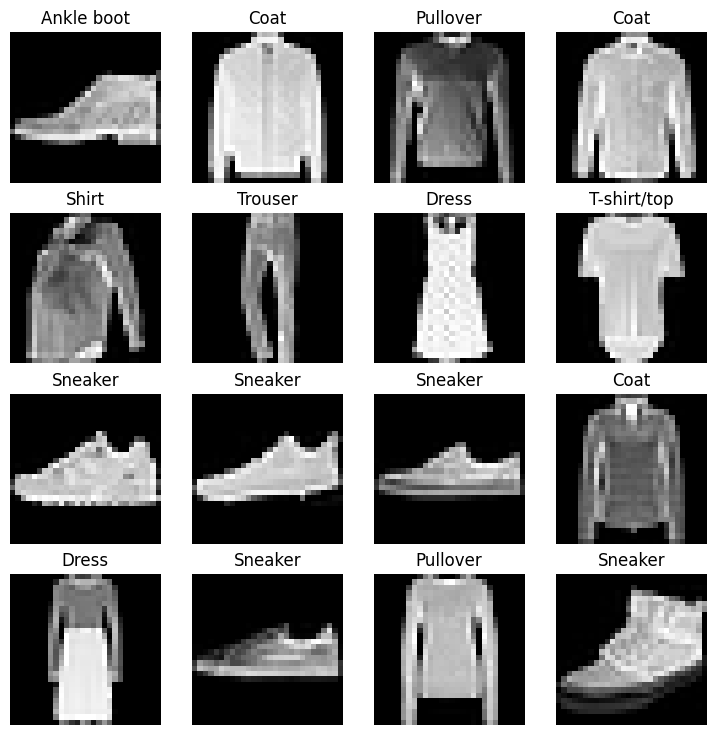

In [94]:
# Plot random images
# torch.manual_seed(RANDOM_SEED)
fig = plt.figure(figsize=(9, 9)) # In inches
rows, cols = 4, 4 # 16 images in 4x4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    print(random_idx)
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)


### Prepare DataLoader

The data is in the form of PyTorch Datasets

Dataset -> Dataloader -> Python Iterable

Turn data in batches/mini-batches so we dont have to look at all 60000 images at the same time. We dont have enough ram/vram to take in a realistic load of 10kk images so we process these in batches to keep the chunks bite sized.

Common batch size is 32, a good starting point.

Batches also give our NN more chances to update its gradients per epoch. 60000 images per epoch would only be 1 update, in batches the gradients are updated ever 32 images.

We may also want to shuffle the data to keep it random.

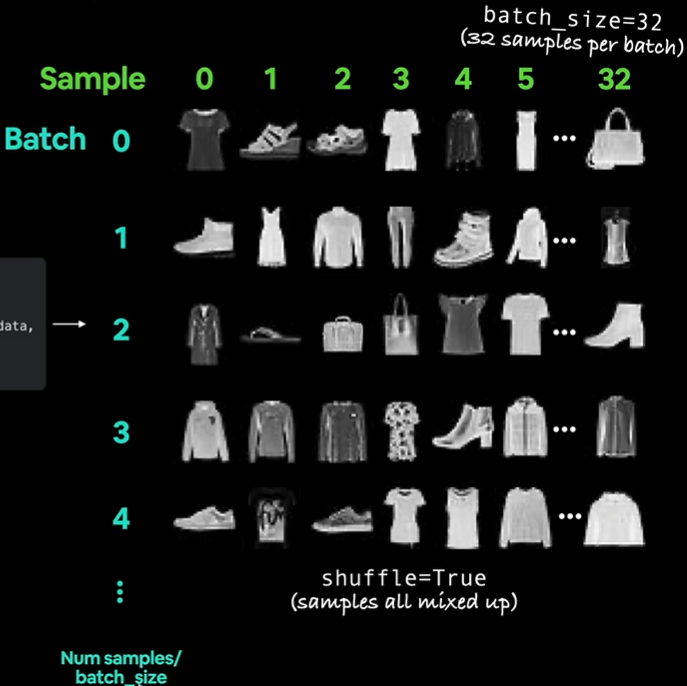

In [95]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [96]:
print(device)

cuda


In [97]:
# Setup batchsize hyperparameter
BATCH_SIZE = 32

# Turn Dataset into interable batches
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)
# Note the test data set probably shouldnt be shuffled so its easier to evaluate
test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1991d368c20>,
 <torch.utils.data.dataloader.DataLoader at 0x1991d36c920>)

In [98]:
# Look at what was created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Dataloader Train Len: {len(train_dataloader)} batch size: {BATCH_SIZE}")
print(f"Dataloader Test Len: {len(test_dataloader)} batch size: {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001991D368C20>, <torch.utils.data.dataloader.DataLoader object at 0x000001991D36C920>)
Dataloader Train Len: 1875 batch size: 32
Dataloader Test Len: 313 batch size: 32


In [99]:
# Check out whats into the trian dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

# This should display the tensor, with Batch size, color channel, height, width

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [100]:
print(device)

cuda


Image shape: torch.Size([1, 28, 28])
Label: 1


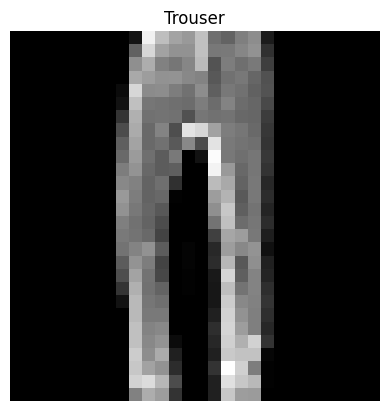

In [101]:
# Show a sample from the batch
torch.manual_seed(RANDOM_SEED)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image shape: {img.shape}")
print(f"Label: {label}")





### Model 0: Build a baseline model

* When building a series of experiments, start with a baseline model
* This should be a relatively simple and flat model
* We will layer complexity later with additional models

In [102]:
print(device)

cuda


In [103]:
# Build a flatten layer, take 2d or more dim input and flatten it to 1d
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]
# x.shape # 1, 28, 28

# Flatten the sample
output = flatten_model(x) # Perform the forward pass

# Print what happened
print(f"Shape before flattening: {x.shape} -> CC, H, W")
print(f"Shape after flattening: {output.shape} -> CC, H*W") # looks like it multiplied the dimensions


Shape before flattening: torch.Size([1, 28, 28]) -> CC, H, W
Shape after flattening: torch.Size([1, 784]) -> CC, H*W


In [104]:
print(device)

cuda


In [105]:
print(device)

class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape,
                      out_features = hidden_units),
            nn.Linear(in_features = hidden_units,
                      out_features = output_shape)
        )
    def forward(self, x):
        return self.layer_stack(x) # Take input x and pass it through the flatten layer then linear layers

print(device)

torch.manual_seed(RANDOM_SEED)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape = 28*28,
                              hidden_units = 10,
                              output_shape = len(class_names)
                              ).to("cpu") # output shape is one per class

model_0

cuda
cuda


FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [106]:
print(device)

cuda


In [107]:
dummy_x = torch.rand([1, 1, 28, 28]) # Create a dummy input
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [108]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### Setup Loss Function and Optimizer, and Evaluation Metrics

* Loss function will be multiclass so `nn.CrossEntropyLoss()`
* Optimizer will be SGD `torch.optim.SGD()`
* Evaluation metric, since this is classification we will use accuracy

In [109]:
print(device)

cuda


In [110]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # This is a classification problem
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)


### Function to time experiments

* Track models performance (loss and accuracy)
* How fast it runs

In [111]:
print(device)

cuda


In [112]:
start_time = timer()
end_time = timer()
print_train_time(start = start_time, end = end_time, device = device)

Training time on cuda: 0.000024900015 seconds


2.4900014977902174e-05

### Creating Training Loop and Training a model with batches

Updates are **once per batch**, not once per epoch, this will update now much more often

1. Loop through epochs
2. Loop through batches, perform training steps, cacl the loss per batch
3. Loop through test batches, perform test steps, calc test loss per batch
4. Print out details
5. Time it

We could use `tqdm` to add a progress bar.

In [113]:
print(device)

cuda


In [114]:
# Set the seed and start timer
torch.manual_seed(RANDOM_SEED)
train_time_start_model_0 = timer()

# Setup epochs, starting small for now
epochs = 3

# Create train/test loop
for epoch in tqdm(range(epochs)): # For tqdm just wrap the iterator in tqdm to track progress
    print(f"Epoch: {epoch}\n------")
    # Training
    train_loss = 0
    # Add a loop to go through the training data
    for batch, (X, y) in enumerate(train_dataloader): # Image and Label, X and y
        model_0.train()
        # Forward pass
        y_pred = model_0(X)
        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate training loss
        optimizer.zero_grad() # Zero the gradients
        loss.backward() # Backpropagate the loss
        optimizer.step()
        # Print out
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
    # Divide total trian loss by len of train dataloader
    train_loss /= len(train_dataloader)
    # Testing loop
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim = 1))
        # Calc test loss average per batch
        test_loss /= len(test_dataloader)
        # Calc test acc average per batch
        test_acc /= len(test_dataloader)
    # Print out the results
    print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}\n")
# End the timer
train_time_stop_model_0 = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_model_0, end = train_time_stop_model_0, device = str(next(model_0.parameters()).device))


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 33%|████████████████████████████                                                        | 1/3 [00:06<00:13,  6.55s/it]


Train Loss: 0.5904 | Test Loss: 0.5095 | Test Acc: 82.0387

Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:13<00:06,  6.53s/it]


Train Loss: 0.4763 | Test Loss: 0.4799 | Test Acc: 83.1969

Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:19<00:00,  6.53s/it]


Train Loss: 0.4550 | Test Loss: 0.4766 | Test Acc: 83.4265

Training time on cpu: 19.594793899974 seconds


### Make predictions and get Model 0 results

In [115]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device = device):
    """Returns a dict containing results of model predictions on data_loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            #X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)
            # Accumulate loss per batch
            loss += loss_fn(y_pred, y)
            # Accumulate accuracy per batch
            acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))
        # Scale loss and acc to find the average per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
    # Return the results as dict
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model = model_0,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device = device)

model_0_results

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 389.85it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

### Model_1 Creat a model with Non-Linear Func, ReLU(), on GPU

In [116]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Outside the video course make a cuda model_1

class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape,
                      out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units,
                      out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units,
                      out_features = output_shape),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Setup model with input parameters, on cuda
model_1 = FashionMNISTModelV1(input_shape = 784,
                              hidden_units = 10,
                              output_shape = len(class_names)
                              ).to(device) # output shape is one per class, sent to gpu

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # This is a classification problem
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)


### Functionizing training and evaluation/testing loops

* training loop - `train_step()`
* testing loop - `test_step()`

In [117]:
print(device)

cuda


In [118]:
# training loop function
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs a training with model on data_loader."""
    train_loss, train_acc = 0, 0
    # Set model to training mode
    model.train()

    for batch, (X, y) in enumerate(data_loader): # Image and Label, X and y
        # Put data on target device
        X, y = X.to(device), y.to(device)
        # Forward pass
        y_pred = model(X)
        # Calculate loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))
        # Zero the gradients
        optimizer.zero_grad()
        # Backpropagation and optimizer step
        loss.backward() 
        optimizer.step()
    # Calc average loss and acc per batch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    # Print training loss
    print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.4f}%")

# Test loop function
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """Performs a test with model on data_loader."""
    test_loss, test_acc = 0, 0
    # Set model to evaluation mode
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Put data on target device
            X, y = X.to(device), y.to(device)
            # Make predictions
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1))
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.4f}%")



In [119]:

# Set the seed and start timer
torch.manual_seed(RANDOM_SEED)
train_time_start_model_1 = timer()

# Setup epochs, starting small for now
epochs = 3

# Create train/test loop
for epoch in tqdm(range(epochs)): # For tqdm just wrap the iterator in tqdm to track progress    
    # call the train step
    train_step(model = model_1,
               data_loader = train_dataloader,
               loss_fn = loss_fn,
               optimizer = optimizer,
               accuracy_fn = accuracy_fn,
               device = device)

    # call the test step
    test_step(model = model_1,
              data_loader = test_dataloader,
              loss_fn = loss_fn,
              accuracy_fn = accuracy_fn,
              device = device)
    
# End the timer
print(device)
train_time_stop_model_1 = timer()
total_train_time_model_1 = print_train_time(start = train_time_start_model_1, end = train_time_stop_model_1, device = str(next(model_1.parameters()).device))



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.92836 | Train Acc: 66.6417%


 33%|████████████████████████████                                                        | 1/3 [00:09<00:18,  9.32s/it]

Test Loss: 0.70984 | Test Acc: 73.4325%
Train Loss: 0.68567 | Train Acc: 74.7483%


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:18<00:09,  9.29s/it]

Test Loss: 0.70210 | Test Acc: 73.9317%
Train Loss: 0.49993 | Train Acc: 82.0317%


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:27<00:00,  9.27s/it]

Test Loss: 0.49066 | Test Acc: 83.1070%
cuda
Training time on cuda:0: 27.823765899986 seconds


### Results Dict for Model 1

In [120]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device = device):
    """Returns a dict containing results of model predictions on data_loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)
            # Accumulate loss per batch
            loss += loss_fn(y_pred, y)
            # Accumulate accuracy per batch
            acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))
        # Scale loss and acc to find the average per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
    # Return the results as dict
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

# Get model_1 results dictionary
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device = device)

print(model_1_results)
print(model_0_results)

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 305.44it/s]

{'model_name': 'FashionMNISTModelV1', 'model_loss': 0.49066317081451416, 'model_acc': 83.1070287539936}
{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.47663894295692444, 'model_acc': 83.42651757188499}


### Model 2: Building a CNN - Convolutional Neural Network

* CNN are good at finding patterns in visual data
* The more layers in the model the more chances to find patterns
* Convolutional Layer -> ReLU Layer -> Pooling Layer -> Repeat
  * This stack of layers is a **Convolutional Block**
* A **Deeper CNN** is a CCN made up of multple Convolutional Blocks

https://poloclub.github.io/cnn-explainer/


In [121]:
# Create CNN
class FashionMNISTModelV2(nn.Module):
    """Model architecture that replicates the TinyVGG model from CNN explainer website."""
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3, # Kernel size is the size of the window
                      stride = 1, # Stride is how many pixels the window moves each time
                      padding = 1), # Padding is how much 0 padding to add around the image
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)) 
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*7*7, # Trick to calculating this
                      out_features = output_shape))
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model_2 = FashionMNISTModelV2(input_shape = 1, 
                              hidden_units = 5, 
                              output_shape = len(class_names)).to(device)
 



### Stepping through `nn.Conv2d()`


In [122]:
print(device)

cuda


In [123]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Create a batch of images
images = torch.randn(size = (32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [124]:
# Create a single nn.Conv2d layer
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size = 3, # 3, 3 tuple or 3 x 3, math operation, how much of the image to look at
                       stride = 1, # how much to move the kernel each time, per pixel, skipping pixels compresses output
                       padding = 1)
# The more you compress the output the more you lose data, but the faster the computation
# If you dont compress at all, you get the same size output as input

# pass the data through the conv layer
conv_output = conv_layer(test_image.unsqueeze(0)) # Add a batch dimension
conv_output.shape

torch.Size([1, 10, 64, 64])

### Stepping through `nn.MaxPool2d()` layer

In [125]:
# Print out original image shape without unsqueezed dim shape
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dim shape: {test_image.unsqueeze(0).shape}")

# Create sample nn.Maxpool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size = 2)

# Pass data through conv_layer first
test_image_through_conv = conv_layer(test_image.unsqueeze(0))
print(f"Shape after conv layer: {test_image_through_conv.shape}")

# Pass data through max_pool_layer
max_pool_output = max_pool_layer(test_image_through_conv)
print(f"Shape after max pool layer: {max_pool_output.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dim shape: torch.Size([1, 3, 64, 64])
Shape after conv layer: torch.Size([1, 10, 64, 64])
Shape after max pool layer: torch.Size([1, 10, 32, 32])


In [126]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Create a random tensor with similar dimensions
random_tensor = torch.randn(size = (1,1,2,2))
print(random_tensor)

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size = 2)

# Pass the random tensor through the max pool layer
max_pool_output = max_pool_layer(random_tensor)
print(max_pool_output)

tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
tensor([[[[0.3367]]]])


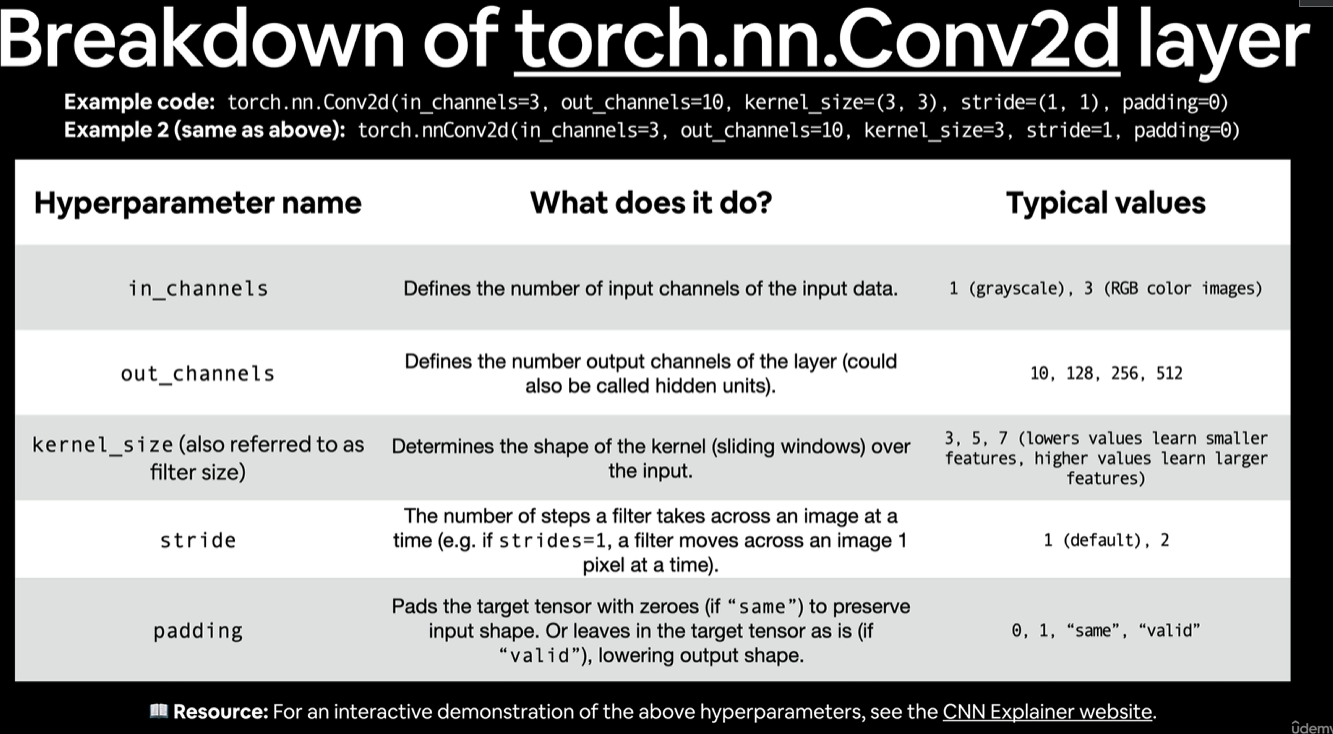

In [127]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [128]:
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[-0.1060, -0.0108, -0.0538,  0.1108, -0.0070,  0.0276, -0.0113, -0.0967,
          0.1528, -0.0225]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [129]:
print(device)

cuda


In [130]:
### Setup loss function, eval metrics, and optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

model_2.state_dict()



OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]]], device='cuda:0')),
             ('c

In [131]:
# Train and evaluate model_2

# Set the seed and start timer
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
train_time_start_model_2 = timer()

# Setup epochs, starting small for now
epochs = 3

# Create train/test loop
for epoch in tqdm(range(epochs)): # For tqdm just wrap the iterator in tqdm to track progress    
    # call the train step
    train_step(model = model_2,
               data_loader = train_dataloader,
               loss_fn = loss_fn,
               optimizer = optimizer,
               accuracy_fn = accuracy_fn,
               device = device)

    # call the test step
    test_step(model = model_2,
              data_loader = test_dataloader,
              loss_fn = loss_fn,
              accuracy_fn = accuracy_fn,
              device = device)
    
# End the timer
print(device)
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start = train_time_start_model_2, end = train_time_end_model_2, device = str(next(model_2.parameters()).device))


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Train Loss: 0.64656 | Train Acc: 76.2567%


 33%|████████████████████████████                                                        | 1/3 [00:10<00:21, 10.89s/it]

Test Loss: 0.44067 | Test Acc: 84.0855%
Train Loss: 0.40170 | Train Acc: 85.5633%


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:21<00:10, 10.81s/it]

Test Loss: 0.39227 | Test Acc: 85.9125%
Train Loss: 0.36547 | Train Acc: 86.7033%


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:32<00:00, 10.77s/it]

Test Loss: 0.36007 | Test Acc: 86.7911%
cuda
Training time on cuda:0: 32.314197600004 seconds


In [132]:
# Get model 2 results
model_2_results = eval_model(model = model_2,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device = device)

print(model_0_results)
print(model_1_results)
print(model_2_results)

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 298.43it/s]

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.47663894295692444, 'model_acc': 83.42651757188499}
{'model_name': 'FashionMNISTModelV1', 'model_loss': 0.49066317081451416, 'model_acc': 83.1070287539936}
{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.3600737154483795, 'model_acc': 86.79113418530352}


### Compare model results and training time with pandas


In [133]:
# Print, Look at the keys for each list of model results
print(model_0_results.keys())
print(model_1_results.keys())
print(model_2_results.keys())

compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results


dict_keys(['model_name', 'model_loss', 'model_acc'])
dict_keys(['model_name', 'model_loss', 'model_acc'])
dict_keys(['model_name', 'model_loss', 'model_acc'])


,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.490663,83.107029
2,FashionMNISTModelV2,0.360074,86.791134


### Add Training Time to Results Comparison

In [134]:
# Add training time to results
compare_results["training_time"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
print(compare_results)


            model_name  model_loss  model_acc  training_time
0  FashionMNISTModelV0    0.476639  83.426518      19.594794
1  FashionMNISTModelV1    0.490663  83.107029      27.823766
2  FashionMNISTModelV2    0.360074  86.791134      32.314198


### Visualize Model Results With a Graph

Text(0, 0.5, 'Model')

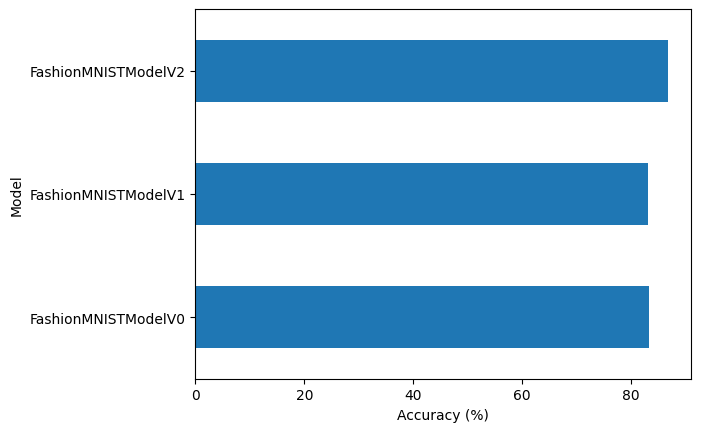

In [135]:
#Visualize the results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy (%)") 
plt.ylabel("Model")

### Make and evaluate random predictions with the best model

In [136]:
print(device)

cuda


In [137]:
# Create a function for making predictions
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    # thing: type or in the case of device set the default value to device
    pred_probs = []
    model.to(device) # this keeps the model device agnostic
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample
            sample = torch.unsqueeze(sample, dim = 0).to(device)
            # Forward pass (model outputs raw Logits)
            pred_logit = model(sample)
            # Get the predicted probability (Logit -> pred prob)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
            # Get pred probs from device
            pred_probs.append(pred_prob.cpu())
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

Text(0.5, 1.0, 'Dress')

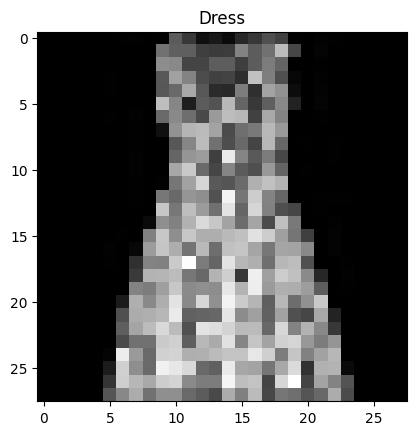

In [138]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first sample shape
test_samples[0].shape

plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [139]:
# Make predictions on random samples
pred_probs = make_predictions(model = model_2, data = test_samples)

# View first two pred probs
pred_probs[:2]

tensor([[1.8497e-02, 5.9737e-03, 7.4617e-04, 9.4864e-01, 1.9031e-04, 7.8364e-05,
         2.4485e-02, 1.7440e-05, 1.2855e-03, 8.6641e-05],
        [2.4294e-04, 7.6193e-07, 3.8924e-06, 2.0176e-06, 1.9181e-06, 9.9670e-01,
         2.5491e-04, 7.2103e-04, 2.0265e-03, 4.1772e-05]])

In [140]:
# Convert prediction pro to labels
pred_classes = pred_probs.argmax(dim = 1)
pred_classes

tensor([3, 5, 4, 2, 5, 9, 1, 0, 4])

In [141]:
test_labels

[3, 5, 2, 4, 5, 9, 3, 6, 4]

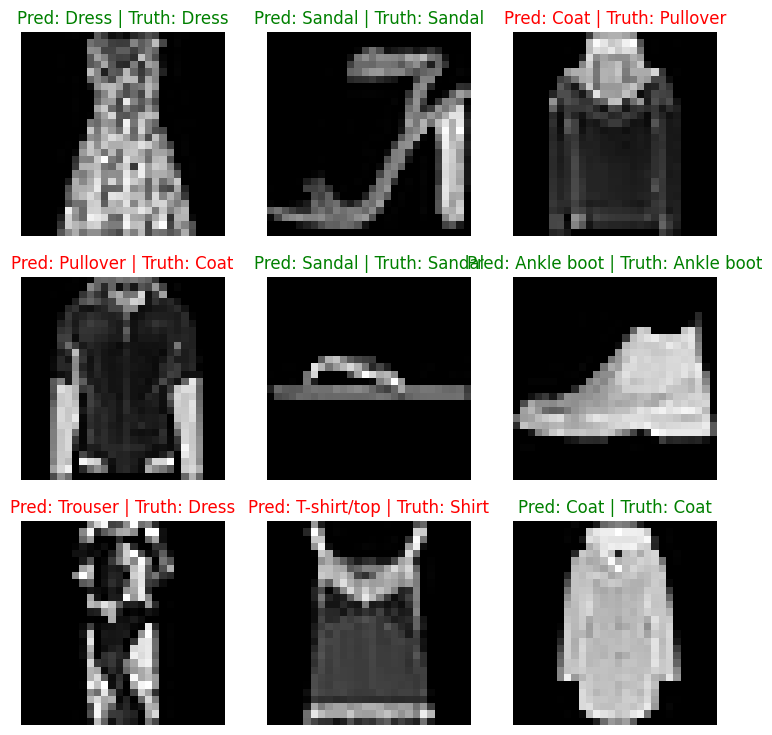

In [142]:
# Plot predictions
plt.figure(figsize = (9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create subplots
    plt.subplot(nrows, ncols, i+1)
    # Plot the image
    plt.imshow(sample.squeeze(), cmap="gray")
    # Find the prediction label in text form
    pred_label = class_names[pred_classes[i]]
    # Get the truth label in text form
    truth_label = class_names[test_labels[i]]
    # Create the titles
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    # Check for equality between pred and truth, change color based on result
    if pred_label == truth_label:
        plt.title(title_text, color = "green")
    else:
        plt.title(title_text, color = "red")
    plt.axis(False)


### Making a confusion matrix for further predictions evaluation

Confusion matrix is a good way to evaluate your classification models visually.

1. Make predictiosn with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix`
    *  This is a good package to get data for testing pytorch models
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()` helper library

In [143]:
print(device)

cuda


In [144]:
# Make predictions on the entire test dataset

# 1 Make pred with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc = "Making Predictions..."):
        # Send to target device
        x, y = X.to(device), y.to(device)
        # forward pass
        y_logit = model_2(X.to(device))
        # Turn preds from logit to pred probs to pred labels
        y_pred = torch.softmax(y_logit.squeeze(), dim = 0).argmax(dim = 1)
        # Put pred on CPU for eval
        y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

print(device)
print(len(y_pred_tensor))

Making Predictions...: 100%|████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 294.33it/s]


[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 5,
        1, 6, 6, 0, 9, 3, 8, 8]), tensor([3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 3, 9, 6, 7, 2, 1, 4, 6, 4, 6, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5]), tensor([1, 3, 3, 3, 7, 8, 7, 0, 2, 3, 4, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2,
        0, 6, 5, 3, 6, 7, 1, 8]), tensor([0, 1, 4, 2, 3, 6, 7, 6, 7, 8, 5, 7, 9, 4, 2, 5, 7, 6, 5, 2, 8, 4, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4]), tensor([1, 8, 4, 1, 9, 1, 8, 6, 6, 1, 2, 5, 1, 6, 0, 0, 1, 6, 1, 3, 2, 6, 3, 4,
        1, 3, 5, 6, 4, 7, 9, 3]), tensor([5, 2, 3, 8, 0, 9, 2, 7, 4, 2, 6, 5, 4, 1, 2, 8, 3, 0, 9, 1, 0, 9, 3, 8,
        7, 9, 9, 4, 4, 7, 1, 2]), tensor([3, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 6, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
        1, 6, 7, 4, 8, 5, 6, 0]), tensor([7, 7, 6, 6, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 3, 2, 5, 3, 9, 2, 2, 8, 6, 2,
        3, 4, 9, 7, 3, 5, 8, 4]), tensor([8, 5, 2, 3, 0, 4, 8, 0, 0, 6, 3, 8, 9, 6, 1, 3, 0, 4, 3, 0, 8, 3, 7, 2,
       

### Confirm/Compare Predictions With Target Labels - Confusion Matrix

In [145]:
test_data.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [146]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

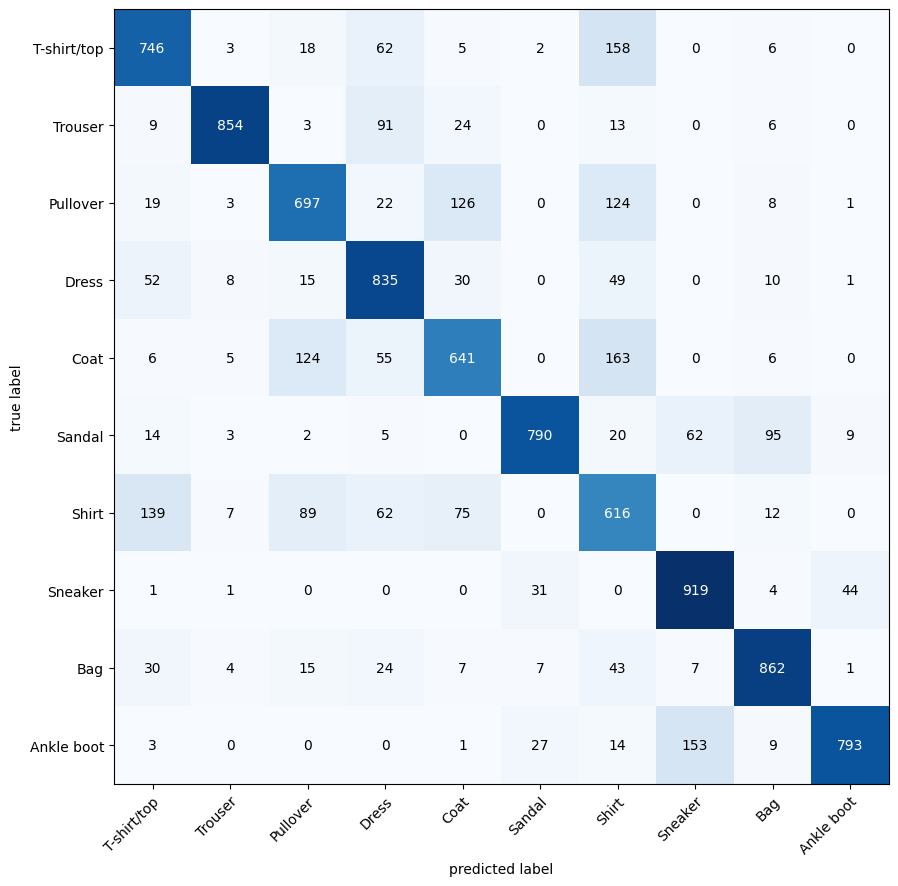

In [147]:
# Setup confusion matrix instance and compare pred to target
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                                class_names = class_names,
                                figsize = (10, 17))

### Save and load best performing model

In [161]:
from pathlib import Path

# Create directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_2.state_dict(), f = MODEL_SAVE_PATH)


Saving model to: models\03_pytorch_computer_vision_model_2.pth


In [162]:
!dir models

 Volume in drive C has no label.
 Volume Serial Number is 08CD-4549

 Directory of C:\GitHub\public\pytorch\Udemy-Pytorch-Class\Course Content\models

11/26/2024  10:18 AM    <DIR>          .
11/14/2024  11:02 AM    <DIR>          ..
11/14/2024  11:02 AM             1,680 01_pytorch_workflow_model_0.pth
11/26/2024  11:47 AM            17,458 03_pytorch_computer_vision_model_2.pth
11/26/2024  10:17 AM            17,458 30_pytorch_computer_vision_model_2.pth
               3 File(s)         36,596 bytes
               2 Dir(s)  369,717,317,632 bytes free


In [163]:
# Create a new instance of the model using saved state dict
torch.manual_seed(RANDOM_SEED)

loaded_model_2 = FashionMNISTModelV2(input_shape = 1, hidden_units = 5, output_shape = len(class_names))

# Load the saved model state dict
loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Send model to device
loaded_model_2.to(device)

C:\Users\user\AppData\Local\Temp\ipykernel_12072\51434472.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=245, out_features=10, bias=True)
  )
)

In [164]:
# Evalute the loaded model
torch.manual_seed(RANDOM_SEED)

loaded_model_2_results = eval_model(model = loaded_model_2,
                                    data_loader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn = accuracy_fn)

loaded_model_2_results

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 224.95it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3600737154483795,
 'model_acc': 86.79113418530352}

In [165]:
# Check if the models are close
torch.isclose(torch.tensor(model_2_results["model_loss"]),
                torch.tensor(loaded_model_2_results["model_loss"]),
                atol = 1e-04) # Absolute tolerance to 4 decimal places



tensor(True)